# Clean up the full train and test datasets

In [323]:
%matplotlib inline

In [324]:
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
import pprint
from IPython.display import display, HTML
from sklearn.preprocessing import Imputer
from sklearn.base import TransformerMixin
from sklearn import linear_model

## Load Data

In [325]:
train_file = "../data/train.csv"
train_orig = pd.read_csv(train_file, index_col=0)
train = train_orig.copy()

test_file = "../data/test.csv"
test_orig = pd.read_csv(test_file, index_col=0)
test = test_orig.copy()


## Clean the data

### Impute the numeric data

In [326]:
cols_numeric = train.select_dtypes(include=[np.number]).columns.tolist()

# Don't want to impute on sale price...
cols_numeric.remove('SalePrice')

# Look down each column and replace missing values with the median of that column 
# (since we're using integers, median seemed to make more sense)
# Imputer is trained on the training data, NOT the test data!
imp_numeric = Imputer(missing_values='NaN', strategy='median', axis=0)
imp_numeric.fit(train[cols_numeric])

# train_imputed = train.copy()
train[cols_numeric] = imp_numeric.transform(train[cols_numeric])
# test_imputed  = test.copy()
test[cols_numeric]  = imp_numeric.transform(test[cols_numeric])

### Handle the non-numeric columns

### sklearn has OneHotEncoder, but pandas now has a built in get_dummies()
see:
* http://fastml.com/converting-categorical-data-into-numbers-with-pandas-and-scikit-learn/
* http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html

Make an imputer for categoricals.  Inherrit the TransformerMixin for .fit and .transform

In [327]:
class CategoricalImputer(TransformerMixin):
    
    def __init__(self):
        """Impute missing categorical values by replacing them with the most common value.
        
        Adapted from http://stackoverflow.com/questions/25239958/impute-categorical-missing-values-in-scikit-learn
        """
        
    def fit(self, X, y=None):
        # Make a pd.Series that has a fill value for each column (use np.nan for anything non-categorical)
        self.fill = pd.Series([X[c].value_counts().index[0] if X[c].dtype == np.dtype('O') else np.nan for c in X ], index=X.columns)
        return self
    
    def transform(self, X, y=None):
        return X.fillna(self.fill)
    
# Example:

# data = [
#     ['a', 1, 2],
#     ['b', 1, 1],
#     ['b', 2, 2],
#     [np.nan, np.nan, np.nan]
# ]

# X = pd.DataFrame(data)
# xt = CategoricalImputer().fit_transform(X)

# print('before...')
# print(X)
# print('after...')
# print(xt)

Get the non-numeric columns


In [328]:
cols_non_numeric = train.select_dtypes(exclude=[np.number]).columns.tolist()


Many columns have nan, but from the description several use nan as a value.  Only fix the ones that shouldn't have nan

In [329]:
# Make lists for datasets that could intentionally have nan (typically they mean "I don't have this feature")
# Any record with a nan in a basement category should have a nan in all basement categories.  Same with garage.  
# Groupd those to check
nan_bsmt = ['BsmtQual', 'BsmtCond', 'BsmtExposure']
nan_garage = ['GarageType', 'GarageQual', 'GarageFinish', 'GarageCond']
nan_intentional = ['Alley', 
                   'FireplaceQu', 
                   'PoolQC', 'Fence', 'MiscFeature',] + nan_bsmt + nan_garage

# Get the other nan's (this would have been easier to just type the unintentional ones, but I was already done listing the intentionals..)
# Need to get nan from both train and test.  Get them separately then combine by using sets
nan_unintentional_train = set([train[cols_non_numeric].iloc[:,x].name for x in pd.isnull(train[cols_non_numeric]).any().nonzero()[0] if train[cols_non_numeric].iloc[:,x].name not in nan_intentional ])
nan_unintentional_test = set([test[cols_non_numeric].iloc[:,x].name for x in pd.isnull(test[cols_non_numeric]).any().nonzero()[0] if test[cols_non_numeric].iloc[:,x].name not in nan_intentional ])
nan_unintentional = list(nan_unintentional_train) + list(nan_unintentional_test-nan_unintentional_train)

nan_rows_train = pd.isnull(train[nan_unintentional]).any(1).nonzero()[0]
nan_rows_train_byId = train.index[nan_rows_train]
nan_rows_test = pd.isnull(test[nan_unintentional]).any(1).nonzero()[0]
nan_rows_test_byId = test.index[nan_rows_test]

imp_categorical = CategoricalImputer()
imp_categorical.fit(train[nan_unintentional])
# train_imputed_categorical = train.copy()
train[nan_unintentional] = imp_categorical.transform(train[nan_unintentional])

# And same for test
test[nan_unintentional] = imp_categorical.transform(test[nan_unintentional])

# Predict using Categoricals

## Simple prediction to see if it is working...

First fit a simple linear regression model relating OverallQual (which is a 1-10 numeric feature) to SalePrice

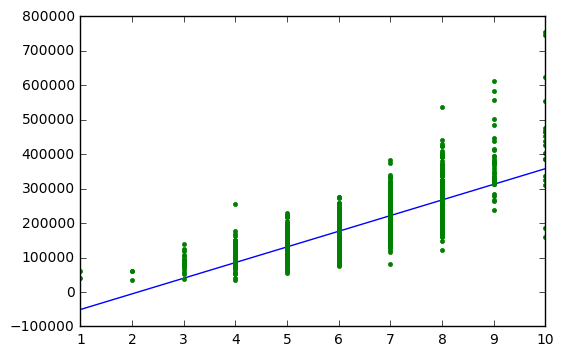

In [330]:
estimator = linear_model.LinearRegression(normalize=True)
estimator.fit(train[['OverallQual']], train['SalePrice'])

x = np.linspace(1,10,10)
dfx = pd.DataFrame(data=x, columns=['OverallQual'])
plt.plot(x, estimator.predict(dfx), '-')
plt.plot(train['OverallQual'], train['SalePrice'], '.')

Now regress by pretending OverallQual is categorical (which it sort of is, it was just represented using numbers).  Use one-hot method to translate "categorical" to boolean features

Index(['OverallQual_2.0', 'OverallQual_3.0', 'OverallQual_4.0',
       'OverallQual_5.0', 'OverallQual_6.0', 'OverallQual_7.0',
       'OverallQual_8.0', 'OverallQual_9.0', 'OverallQual_10.0'],
      dtype='object')


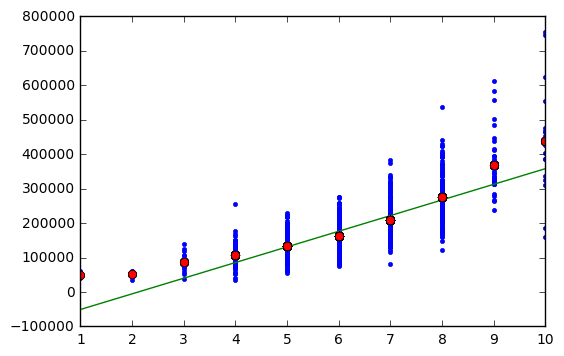

In [331]:
train_simple_OQ = pd.get_dummies(train[['OverallQual']], columns=['OverallQual'])

# Leave one out as you need k-1 indicators for k total results (think of how you need one boolean indicator to represent two results)
features = train_simple_OQ.columns[1::]
print(features)
m = linear_model.LinearRegression(normalize=True) # Does normalize do anything here?
m.fit(train_simple_OQ[features], train['SalePrice'])

# This is overkill on the plotting.  I could just make a very simple identity matrix to plot all these predictions.
# ...but I'm lazy..
plt.plot(train['OverallQual'], train['SalePrice'], '.')
plt.plot(x, estimator.predict(dfx), '-')
plt.plot(train['OverallQual'], m.predict(train_simple_OQ[features]), 'o')

Looks even better than the linear regression on the numerics!  ...Although it has more features...

Investigating the model we get

In [332]:
print(m.intercept_)
list(zip(features, m.coef_))

50150.0


[('OverallQual_2.0', 1620.3333333350231),
 ('OverallQual_3.0', 37323.750000001535),
 ('OverallQual_4.0', 58270.655172415318),
 ('OverallQual_5.0', 83373.347607054005),
 ('OverallQual_6.0', 111453.03475935977),
 ('OverallQual_7.0', 157566.42319749325),
 ('OverallQual_8.0', 224585.53571428699),
 ('OverallQual_9.0', 317363.02325581585),
 ('OverallQual_10.0', 388438.38888889045)]

Ok this makes sense.  So having a quality of say 8 adds $225000 to your house

Note: If we had left OverallQual_10 out, we'd instead have a very high intercept and lots of negative values

## Slightly more advanced fit: sqft + OverallQual

### Filter outliers (like in the previous sqft only case)

Training data:


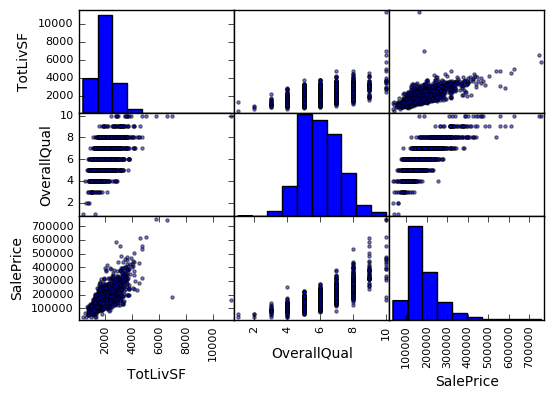

Test data:


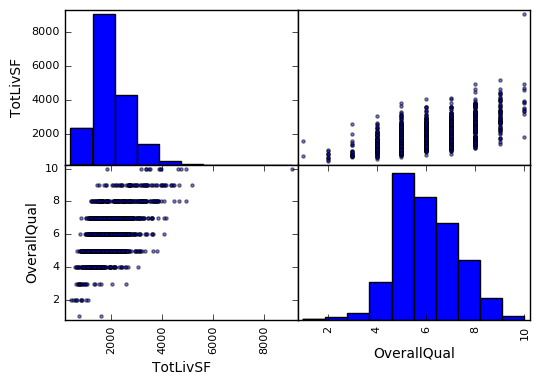

In [333]:
# View the univariate and multivariate interactions for the data using a scatter_matrix
print("Training data:")
scatter_matrix(data['train'][['TotLivSF', 'OverallQual', 'SalePrice']])
plt.show()
print("Test data:")
scatter_matrix(data['test'][['TotLivSF', 'OverallQual']])
plt.show()


From this it looks like the OverallQual is relatively gaussian, and the TotLivSF is also except for a few outliers.  

Let's try to quantify the outliers a little more rigorously.

In [334]:
def outliers_numerical(data, m=2.):
    """Return a boolean array of outliers given numerical data.
    
    Outliers are assessed given:
      m > (x-median(X)) / median(x-median(x))
    if their median(x-median(x)) != 0,
    eg: multiples of the typical distance from the median.
    
    If median(x-median(x)) == 0, mean(x-median(x)) is used as the normalizer:
      m > (x-median(X)) / mean(x-median(x))
    """
    d = np.abs(np.asarray(data) - np.median(np.asarray(data)))
    # Use median if possible, but if median comes out 0 then use mean as a fallback
    mdev = np.median(d)
    s = d/mdev if mdev else d/np.mean(d)
    return ~(s<m)

For the train and test data, quantify how many data points would be considered outliers given different values of m

In [335]:
print("{:>3s}  {:9s} {:9s}".format('m', 'TotLivSF', 'OvrlCond'))
print("{:3s}  {:4s} {:4s} {:4s} {:4s}".format('', 'Trn', 'Test', 'Trn', 'Test'))
for i in range(0,10):
    sf = []
    oc = []
    for ds in ['train', 'test']:
#         print(outliers_numerical(data[ds]['TotLivSF'], i))
#         print(outliers_numerical(data[ds]['OverallCond'], i))
        sf.append(outliers_numerical(data[ds]['TotLivSF'], i).sum())
        oc.append(outliers_numerical(data[ds]['OverallQual'], i).sum())
    
    print("{:3d}: {:4d} {:4d} {:4d} {:4d}".format(i, sf[0], sf[1], oc[0], oc[1]))

  m  TotLivSF  OvrlCond 
     Trn  Test Trn  Test
  0: 1460 1459 1460 1459
  1:  733  730 1086 1102
  2:  314  296  370  393
  3:  119  125   86  109
  4:   51   61   23   25
  5:   23   26    2    2
  6:   11   13    0    0
  7:    5    4    0    0
  8:    4    2    0    0
  9:    4    1    0    0


Not sure where to draw the line here...  Would this be the sort of thing we could examine on a train/validation data set split?

Arbitrarily, let's say anything more than m=7 is an outlier. To visualize:

TotLivSF
5
OverallQual
0


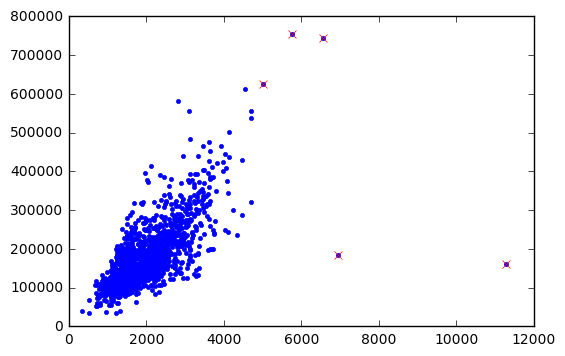

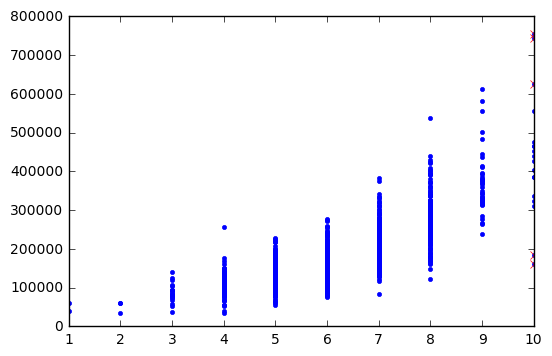

In [336]:
m = 7
mask = np.array([False] * len(data['train'].index))
features = ['TotLivSF', 'OverallQual']
for f in features:
    print(f)
    print(outliers_numerical(data['train'][f], m).sum())
    mask = (mask) | outliers_numerical(data['train'][f], m)

# Not sure why, but dataframe.plot wont take my style specifications...
# ax = data['train'].plot(x='TotLivSF', y='SalePrice', kind='scatter')
# data['train'].loc[1000:,:].plot(x='TotLivSF', y='SalePrice', kind='scatter', style='x')
# data['train'].hist(column='TotLivSF')
# Go straight to the source instead!
plt.plot(data['train']['TotLivSF'], data['train']['SalePrice'], 'b.')
plt.plot(data['train'].loc[mask, 'TotLivSF'], data['train'].loc[mask, 'SalePrice'], 'rx')
plt.show()
plt.plot(data['train']['OverallQual'], data['train']['SalePrice'], 'b.')
plt.plot(data['train'].loc[mask, 'OverallQual'], data['train'].loc[mask, 'SalePrice'], 'rx')
plt.show()

Other ideas for filtering:
http://machinelearningmastery.com/how-to-identify-outliers-in-your-data/

Some examples
* Nearest neighbor
* Error from linear regression
* ...

Now filter out the outliers in the training data

In [337]:
print("Count before dropping outliers: {}".format(len(train.index)))
train.drop(train.index[mask], inplace=True)
print("Count after dropping outliers: {}".format(len(train.index)))

Count before dropping outliers: 1460
Count after dropping outliers: 1455


### Make New Features

In [338]:
def feat_eng_polys(df, feat, pwrs, inplace=True):
    """
    Given a dataframe and a feature, return a new (add to existing?) dataframe new features that are the pwrs'th power of the feature.
    
    :param pwrs:
        NOT IMPLEMENTED If pwrs=int, return all powers from 1 to that number.
        NOT IMPLEMENTED If pwrs=float, return that power.
        If pwrs=iterable, return the powers included in pwrs
    """
    f_new = []
    if inplace is not True:
        df_new = pd.DataFrame(index=df.index)
    else:
        df_new = df
    for p in pwrs:
        f_new.append('{:s}_{:s}'.format(feat, str(p)))
        df_new[f_new[-1]] = df[feat] ** p

    # Does it matter if this gets returned when doing inplace=True?
    return df_new, f_new

In [339]:
def get_RSS(d1, d2):
    npa1 = np.asarray(d1)
    npa2 = np.asarray(d2)
    if npa1.shape != npa2.shape:
        raise ValueError("Found arrays of shape {} and {} - shape of arrays must be the same.".format(npa1.shape, npa2.shape))
    return ((np.asarray(d1) - np.asarray(d2)) ** 2).sum()
def get_RMS(d1, d2):
    return np.sqrt(get_RSS(d1, d2)) / len(d1)

Add new features
* TotLivSF
* TotLivSF^N
* One-hot of OverallQual

In [340]:
# Copies here are inefficient but useful for debugging...
data = {'train': train.copy(),
        'test': test.copy()}

cat_features = ['OverallQual']

for k in data.keys():
    # Make Total Living Square Footage
    data[k].loc[:, 'TotLivSF'] = data[k]['GrLivArea'] + data[k]['BsmtFinSF1'] + data[k]['BsmtFinSF2']
    # And sqrt of that
#     data[k][:, 'TotLivSF_sqrt'] = np.sqrt(data[k]['TotLivSF'])
    # And 2nd to 5th power
    data[k], f_new_poly  = feat_eng_polys(data[k], 'TotLivSF', range(2,6), inplace=True)
    
    # Add one-hot categoricals
    # Not sure if this is the best way to get the features, but using a temp variable to store the new features.
    # Could also get a set of data[k].columns before and after and take the difference
    temp =  pd.get_dummies(data[k][cat_features], columns=cat_features)
    f_new_cat = list(temp.columns)
    data[k] = pd.concat([data[k], temp], axis=1)
    
# Make a features list including the new polys and all the categoricals but one
features = ['TotLivSF'] + f_new_poly + f_new_cat[1:]
print("Features for fitting: {0}".format(features))


Features for fitting: ['TotLivSF', 'TotLivSF_2', 'TotLivSF_3', 'TotLivSF_4', 'TotLivSF_5', 'OverallQual_2.0', 'OverallQual_3.0', 'OverallQual_4.0', 'OverallQual_5.0', 'OverallQual_6.0', 'OverallQual_7.0', 'OverallQual_8.0', 'OverallQual_9.0', 'OverallQual_10.0']


### Train a RidgeCV model using these features

In [341]:
alphas = np.logspace(-6,5,12)
m = linear_model.RidgeCV(normalize=True, alphas=alphas)
m.fit(data['train'][features], train[['SalePrice']])

RidgeCV(alphas=array([  1.00000e-06,   1.00000e-05,   1.00000e-04,   1.00000e-03,
         1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05]),
    cv=None, fit_intercept=True, gcv_mode=None, normalize=True,
    scoring=None, store_cv_values=False)

In [342]:
print(m.coef_)

[[  5.07919275e+01  -3.93025325e-03  -2.17070896e-07   1.04314637e-10
    4.41788941e-14   1.32668938e+03   1.45952977e+04   2.65934114e+04
    3.84803329e+04   5.85190680e+04   9.63270584e+04   1.42325296e+05
    2.17406928e+05   2.41281853e+05]]


In [343]:
predictions = m.predict(data['train'][features])
RMS = get_RMS(data['train'][['SalePrice']], predictions)
RSS = get_RSS(data['train'][['SalePrice']], predictions)
print("RSS={:8e}, RMS={:8.2f}".format(RSS, RMS))

RSS=1.420068e+12, RMS=  819.01


I am not sure if I should really look at this RMS value, or if I should look only at a cross validation score.  Need to look that up...

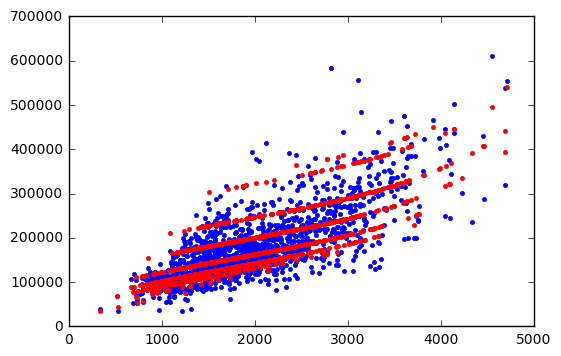

In [344]:
plt.plot(data['train']['TotLivSF'], data['train']['SalePrice'], 'b.')
plt.plot(data['train']['TotLivSF'], m.predict(data['train'][features]), 'r.')

I should really check this against the original data with outliers and see what it does, too.

### Apply RidgeCV model to predict test results

In [345]:
predictions_test = pd.DataFrame(m.predict(data['test'][features]), columns=['SalePrice'], index=test.index, )

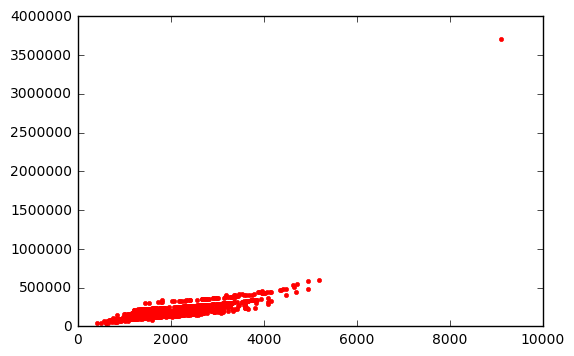

In [346]:
plt.plot(data['test']['TotLivSF'], predictions_test['SalePrice'], 'r.')

We still have the super outlier...  But this time it is positive at least.  Don't bother fudging it.

Notes:
* This seems to improve on the sqft-only model!  Not by a ton, but still something.
* FYI, if I skip the filtering of the data above, this gets a slightly worse score on the test data (although that's not really a good way of checking that sort of thing)

In [347]:
predictions_test.to_csv('test_predictions_sqft_OverallQual_with-outlier-filter.csv')

## Next Steps
* Add a few extra categoricals to that same model.
* Expand to the entire set of categoricals and apply with RidgeCV.  How crazy does that get?  Does it give a better fit?
* Use the entire set of categoricals with LassoCV.  How good is that fit?
* Use LassoCV's selected features and then refit with RidgeCV.  Improvement on Lasso?
* Use the feature selection from scipy, does the feature set seem similar to Lasso?  Try Ridge with those features...  
* Were there other things I used in the sqft/simple model?